# What is Feedback?
Ryan Dwyer 2015.03.25 *Updated: 2016.07.12*

Inspired by the article [Feedback for Physicists](http://dx.doi.org/10.1103/RevModPhys.77.783)

# Where do we use feedback?
- positive feedback to drive cantilever (feedback on cantilever displacement)
- PLLpro uses feedback to lock to cantilever  (feedback on cantilever phase)
- AFM (feedback on cantilever amplitude)
- EFM (feedback on cantilever tip voltage)
- All of our op-amp circuits use feedback to control gain / phase response
- Potentiostat uses feedback establish current / voltage through cell
- Lasers have feedback loops to control laser temperature

# Outline
- Tools
- Motivating examples
- Stability
- Basic feedback building blocks

# Tools

## Response function

Consider filtering an input signal $x(t)$ to produce an output $y(t)$. We can represent the action of the filter by convolution with a function $h(t)$

$$y(t) = h(t) * x(t)$$

as long as the filter is [linear and time-invariant](http://en.wikipedia.org/wiki/LTI_system_theory).

## Laplace Transform

The Laplace transform, defined as,

$$ x(s) = \mathcal{L}[x(t)] = \int x(t) e^{-s t}\; dt$$

allows this to be written as,

$$y(s) = H(s) x(s)$$

## Transfer function

We call 

$$H(s) = \frac{y(s)}{x(s)}$$

the transfer function.

To determine the frequency response of a given filter / LTI system, evaluate $H(s)$ at

$$s = i \omega = 2 \pi i f$$


# Time and Laplace domains

<img src="LTI.png" alt="Laplace transform" style="width: 800px;"/>

## Bode plot

We can summarize the frequency response of a filter using a Bode plot, which gives magnitude and phase vs. frequency.

<img src="bode-plot.png" alt="Bode plot from Feedback for Physicists" style="width: 600px;"/>

## Decibels

The transfer function magnitude is normally expressed in decibels,

$$\left ( \frac{V_{\text{out}}}{V_{\text{in}}} \right )_{\text{dB}} = 20 \log_{10} \left ( \frac{V_{\text{out}}}{V_{\text{in}}} \right )$$

On this scale,

<table>
<tr>
<th>Ratio</th>
<th>Decibels</th>
</tr>
<tr>
<td>$$10$$</td>
<td>$$20$$</td>
</tr>
<tr>
<td>$$1$$</td>
<td>$$0$$</td>
</tr>
<tr>
<td>$$\frac{1}{\sqrt{2}}$$</td>
<td>$$-3$$</td>
</tr>
<tr>
<td>$$\frac{1}{2}$$</td>
<td>$$-6$$</td>
</tr>
<tr>
<td>$$\frac{1}{10}$$</td>
<td>$$-20$$</td>
</tr>
</table>

1 dB corresponds, roughly, to a 10 percent change in magnitude.

## Python

- [Sympy](http://www.sympy.org/) for *Mathematica* style symbolic math.
- The [Scipy signal processing](http://docs.scipy.org/doc/scipy/reference/signal.html) module for quickly computing time-domain responses, filter coefficients. The scipy signal processing module copies Matlab's signal processing functionality.

## Example: EFM

Goal: Have $y(t)$ faithfully reproduce $r(t)$. To make the example concrete, let $r(t)$ be surface potential $\phi(t)$, $y(t)$ applied DC potential $V_\text{DC}(t)$

![feedback loop](feedback-loop.png)

- $e(t)$ is the error, $\phi - V_\text{DC}$
- $u(t)$ is the measured X-channel lock-in, which is the error, filtered and delayed by the lock-in time constant, etc. $K(s) = u(s)/e(s)$
    - In principle, the way we have written it right now, $K(s)$ includes any contribution from the cantilever, frequency demodulation, and lock-in output / filter settings. We could break this into more terms if it were important.
- $y(t) = V_\text{DC}(t)$, which is the output of the PID loop ($G(s) = y(s) / u(s)$)
- Arrow from output to summing node provides feedback.


## Finding the transfer function

With the Laplace / Fourier transform, we can write the overall transfer function of our system using simple algebra (as opposed to convolution / deconvolution or solving differential equations).

<img src="feedback-loop.png" alt="feedback loop" style="width: 405px;"/>

The overall system transfer function $T(s) = y(s)/r(s)$ can be written as,

The output $y(s)$ is,

$$y(s) = G(s)K(s)e(s)$$

The error $e(s)$ is,

$$e(s) = r(s) - y(s)$$

Then we can substitute for $e(s)$ to get,

$$y(s) = G(s)K(s)\left [ r(s) - y(s)\right ]$$

Solving for the transfer function $T(s)$ gives,

$$\frac{y(s)}{r(s)} = T(s) = \frac{G(s)K(s)}{1+G(s)K(s)}$$


In [1]:
# Uncomment the following line to install sympy
#!pip install sympy pint

In [2]:
%matplotlib inline
from __future__ import division
from ipywidgets import interact, FloatSlider, IntSlider, interact_manual
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sm
import pandas as pd
from scipy import signal
import inspect
# Print sympy quantities using nice LaTeX
sm.init_printing()

# Lots of symbols that are useful for this material
f = sm.symbols('f', real=True)
omega = sm.symbols('omega', real=True)
tau = sm.symbols('tau', positive=True)
tau_d = sm.symbols('tau_d', positive=True)
s = sm.symbols('s')
k = sm.symbols('k', real=True)
f_c = sm.symbols('f_c', positive=True)
s_c = sm.symbols('s_c')
k_c = sm.symbols('k_c', positive=True)
V_0 = sm.symbols('V_0', positive=True)
alpha = sm.symbols('alpha', positive=True)
d = sm.symbols('d', positive=True)
K_R = sm.symbols('K_R', real=True)
omega_0 = sm.symbols('omega_0', real=True)
omega_R = sm.symbols('omega_R', real=True)
omega_L = sm.symbols('omega_L', real=True)
K_i = sm.Symbol('K_i', real=True)
K_p = sm.Symbol('K_p', real=True)
K_d = sm.Symbol('K_d', real=True)
T_s = sm.Symbol('T_s', positive=True)
z = sm.symbols('z', real=True)
z_i = sm.Symbol('z_i', real=True)

# Continuous to discrete transformation
pade = {s:2/T_s*(1-z**-1)/(1+z**-1)}


In [3]:
# Bode plot utility functions
def dB_sm(x):
    return 20*sm.log(sm.Abs(x), 10)

def dB(x):
    return 20*np.log10(np.abs(x))

def adjust_y_ticks(ax, delta):
    ylim = np.array(ax.get_ylim()) / delta
    ymin = ylim[0]//1  # Round towards - infinity
    ymax = -(-ylim[1]//1)  # Trick to round towards + infinity
    # Note: this rounds away from zero so we never make the axis limits smaller
    ax_new_lim = np.array([ymin, ymax]) * delta
    ax_new_ticks = np.arange(ax_new_lim[0], ax_new_lim[1]+1, delta)
    ax.set_ybound(*ax_new_lim)
    ax.set_yticks(ax_new_ticks)

def find_gain(mag, gain):
    if mag.max() > gain:
        return np.max(np.flatnonzero(mag > gain))
    else:
        return 0
    
def unity_gain(mag):
    return find_gain(mag, 0)
    
def phase_margin(mag, phase):
    return ((phase[unity_gain(mag)] % 360) - 180)  

def bode_f(func, xlim, N):
    f_min = xlim[0]
    f_max = xlim[1]
    f = np.logspace(np.log10(f_min), np.log10(f_max), N)
    
    transfer = func(f)
    mag = dB(transfer)
    phase = 180/np.pi*np.unwrap(np.angle(transfer))
    return f, mag, phase

def bode_f_kwargs(func, xlim, N, **kwargs):
    f_min = xlim[0]
    f_max = xlim[1]
    f = np.logspace(np.log10(f_min), np.log10(f_max), N)
    
    transfer = func(f, **kwargs)
    
    try:
        mag = dB(transfer)
        phase = 180/np.pi*np.unwrap(np.angle(transfer))
    except:
        print(transfer)
        raise
        
    return f, mag, phase

def get_bode_s(laplace, s, xlim, N=1000):
    f = sm.Symbol('f')
    laplace_numpy = sm.lambdify([f], laplace.subs(s, 2j*np.pi*f), modules='numpy')
    
    return bode_f(laplace_numpy, xlim, N)

def bode_quantities(loop_transfer, var, xlim, N):
    numerical_transfer = sm.lambdify(var, loop_transfer, modules='numpy')
    
    return bode_f(numerical_transfer, xlim, N)
    

def bode_plot(loop_transfer, var, xlim, N=1000, gain_point=0, mag_lim=None, phase_lim=None, figax=None):
    data = f_range, magnitude, phase = bode_quantities(loop_transfer, var, xlim, N)
    
    gain_index = find_gain(magnitude, gain_point)
    print(u"Freq at gain: {:.2g}".format(f_range[gain_index]))
    print(u"Phase at gain: {:.0f}°".format(phase[gain_index]))
    
    return bode(f_range, magnitude, phase, gain_point, xlim, mag_lim, phase_lim, figax)

def bode(freq, mag, phase, gain_point=0, xlim=None, mag_lim=None, phase_lim=None, figax=None):
    """Make a nice bode plot for the given frequency, magnitude, and phase data.
    
    If provided, xlim is the xlimits to set on the plot.
    If provided, mag_lim is a tuple with (mag_min, mag_max, mag_delta),
    and phase is also a tuple of the same type."""
    gain_index = find_gain(mag, gain_point)
    with mpl.rc_context({'figure.figsize': (8,6), 'lines.linewidth': 1.5, 'figure.dpi':300, 'savefig.dpi': 300, 'font.size': 16,}):
        if figax is None:
            fig, (ax1, ax2) = plt.subplots(nrows=2)
        else:
            fig, (ax1, ax2) = figax
        ax1.yaxis.grid(True, linestyle='-', color='.8')
        ax2.yaxis.grid(True, linestyle='-', color='.8')
        ax1.semilogx(freq, mag)

        if xlim is not None:
            ax1.set_xlim(*xlim)
        if mag_lim is not None:
            ax1.set_ylim(mag_lim[0], mag_lim[1])
            adjust_y_ticks(ax1, mag_lim[2])
        else:
            adjust_y_ticks(ax1, 20)
    
        ax1.axvline(x=freq[gain_index], color='k',  linestyle='--')

        ax2.semilogx(freq, phase, linewidth=1.5)
        
        if xlim is not None:
            ax2.set_xlim(*xlim)
        if phase_lim is not None:
            ax2.set_ylim(phase_lim[0], phase_lim[1])
            adjust_y_ticks(ax2, phase_lim[2])
        else:
            adjust_y_ticks(ax2, 30)

        ax2.axvline(x=freq[gain_index], color='k',  linestyle='--')
        ax1.set_ylabel('Magnitude [dB]')
        ax2.set_ylabel('Phase [degrees]')
        ax2.set_xlabel('Frequency')
        fig.tight_layout()
        fig.show()
        return fig, (ax1, ax2)
    
def bode_plot_s(loop_transfer, var, xlim, N=1000, gain_point=0, mag_lim=None, phase_lim=None, figax=None):
    """Create a bode plot for a sympy transfer function, expressed in terms of var s,
    plotted over a frequency range given in xlim.
    
    Other parameters described below.
    
    N is the number of points to calculated the transfer function at.
    gain_point determines where to draw a line on the plot
        this can be used to highlight the unity gain bandwidth, or the -3 dB point of a filter.
    
    mag_lim gives the magnitude axis limits as a tuple (low, high, tick_spacing)
    phase_lim gives the phase axis limits as a tuple (low, high, tick_spacing)
    figax allows the figure to be drawn on axes you provide, rather than a new set of axes.
        It should be a nested tuple, (fig, (ax1, ax2))
    """
    f = sm.symbols('f', real=True)
    return bode_plot(loop_transfer.subs(var, 2*sm.pi*sm.I*f), f, xlim, N, gain_point, mag_lim, phase_lim, figax)

def bode_plot_f(func, xlim, N, gain_point=0, mag_lim=None, phase_lim=None, **kwargs):
    freq, magnitude, phase =  bode_f_kwargs(func, xlim, N, **kwargs)
    gain_index = find_gain(magnitude, gain_point)
    print(u"Freq at gain: {:.2g}".format(freq[gain_index]))
    print(u"Phase at gain: {:.0f}°".format(phase[gain_index]))
    return bode(freq, magnitude, phase, gain_point=gain_point, mag_lim=mag_lim, phase_lim=phase_lim)

def bode_plot_interact(loop_transfer, var, xlim, N=1000, gain_point=0, mag_lim=None, phase_lim=None, subs={}, plot_kwargs={}):
    """A utility function for interacting with sympy transfer functions. Put variables to vary in subs, with the tuple you would
    pass to interact (min, max, delta), such as,
    
    {omega_0: (0, 1, 0.01)}"""
    f = sm.symbols('f', real=True)
    loop_transfer_f = loop_transfer.subs(var, 2j*sm.pi*f)
    
    variables = [f]
    variables.extend(subs.keys())
    func = sm.lambdify(variables, loop_transfer_f, dummify=False, modules='numpy')
    
    args = inspect.getargspec(func).args
    args.remove('f')
    new_kwargs = {key:val for key, val in zip(args, subs.values())}
    
    def _interact_f(**kwargs):
        print(kwargs)
        if 'gain_point' in plot_kwargs:
            return bode_plot_f(func, xlim, N, mag_lim=mag_lim, phase_lim=phase_lim, **kwargs)
        else:
            return bode_plot_f(func, xlim, N, gain_point=gain_point, mag_lim=mag_lim, phase_lim=phase_lim, **kwargs)
    
    new_kwargs.update(plot_kwargs)
    
    interact(_interact_f, **new_kwargs)
    

In [4]:
def difference_coeffs_exact(laplace, s):
    """Symbolic expression of numerator, denominator"""
    z = sm.symbols('z')
    z_i = sm.symbols('z_i')
    T_s = sm.symbols('T_s')
    pade = {s:2/T_s*(1-z**-1)/(1+z**-1)}
    numer_denom = laplace.subs(pade).subs({z:1/z_i}).simplify().as_numer_denom()
    numer_denom_coeffs = [sm.Poly(expr, z_i).all_coeffs() for expr in numer_denom]
    a0 = numer_denom_coeffs[1][-1]
    b = [x/a0 for x in numer_denom_coeffs[0][-1::-1]]
    a = [x/a0 for x in numer_denom_coeffs[1][-1::-1]]
    return (b, a)

def discrete(laplace, s, z_i, Ts):
    """Output b, a, dt in a form which can be used by scipy.signal.lfilter"""
    
    # z_i is shorthand for z**-1
    T_s = sm.symbols('T_s')
    pade = {s:2/T_s*(1-z_i)/(1+z_i)}
    numer_denom = laplace.subs(pade).simplify().subs(T_s, Ts).as_numer_denom()
    try:
        numer_denom_coeffs = [np.array(sm.Poly(expr, z_i).all_coeffs(), dtype=np.float64) for expr in numer_denom]
    except TypeError:
        print(sm.Poly(numer_denom[0], z_i).all_coeffs())
        raise
    
    a0 = numer_denom_coeffs[1][-1]
    b = numer_denom_coeffs[0][-1::-1]/a0
    a = numer_denom_coeffs[1][-1::-1]/a0
    return (b, a, Ts)

# Proportional control of a low-pass filter sensor

- Let's look at the time-domain response of a simple system under feedback.

In [5]:
low_pass = 1/(1+s/omega_0)
(b, a, dt) = signal.cont2discrete(signal.butter(1, 2*np.pi, analog=True), dt=0.001, method='bilinear')
t = np.arange(0, 10, dt)
x_sq = np.where(t>2, 1,0)
b2, a2, dt2 = discrete(low_pass.subs(omega_0, 2*np.pi), s, z_i, 0.001)
b3, a3, dt3 = discrete(100*low_pass.subs(omega_0, 2*np.pi)/(1+100*low_pass.subs(omega_0, 2*np.pi)), s, z_i, 0.001)
signal.cont2discrete(signal.butter(1, 2*np.pi, analog=True), dt=0.001, method='bilinear')
y = signal.lfilter(b[0], a, x_sq)
transfer = K_p*low_pass/(1+K_p*low_pass)

In [6]:
def proportional_interact(Kp, f0):
    df = 1e-3
    subs = {K_p: Kp,
            omega_0: 2*np.pi*f0}
    b_lp, a_lp, _ = discrete(low_pass.subs(subs), s, z_i, dt)
    y_lp = signal.lfilter(b_lp, a_lp, x_sq)
    b_fb, a_fb, _ = discrete(transfer.subs(omega_0, 2*np.pi*f0).subs(K_p, Kp), s, z_i, 0.001)
    y_fb = signal.lfilter(b_fb, a_fb, x_sq)
    plt.plot(t, x_sq, 'b-', t, y_lp, 'g-', t, y_fb, 'r-', linewidth=1.5)
    plt.xlim(1.9, 3)
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Time [s]")
    plt.ylabel("Output")

The below example shows,

- $K(s)$ a low-pass filter
- $G(s)$ proportional control

<img src="feedback-loop.png" alt="feedback loop" style="width: 500px;"/>

- <p style="color:blue"> input signal $r(t)$ </p>
- <p style="color:red"> sensor output $u(t)$ </p>
- <p style="color:green"> control output $y(t)$ </p>



<function __main__.proportional_interact>

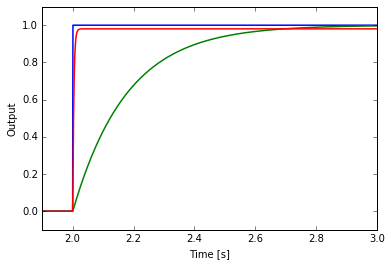

In [7]:
interact(proportional_interact, Kp=(1, 100, 1), f0=(0.5, 1.5, 0.1))

- `Kp` is the proportional gain
- `f0` is the low-pass filter frequency

- Feedback used to speed up response
- Steady state error $1/K_p$ (proportional droop)
- High gain makes response insensitive to variations in $f_0$ (compare changes in green curve to changes in red curve)

# PID control of a low-pass filter sensor with delay

To make our example more realistic, let's add a small delay to our sensor (3 ms) and add an integral term to our controller.

In [8]:
lp_delay = sm.exp(-s*tau_d)/(1+s/omega_0)
control = K_p*(K_i/s + 1 + K_d * s)
open_loop = lp_delay*control
closed_loop = open_loop/(1+open_loop)

In [9]:
e2_b, e2_a, e2_dt = discrete(lp_delay.subs(omega_0, 2*np.pi).subs(sm.exp(-s*tau_d), z_i**(tau_d/T_s)).subs(tau_d/T_s, 3), s, z_i, 0.001)
e2_y2 = signal.lfilter(e2_b, e2_a, x_sq)

def pid_interact(delay, Ki, Kp, Kd):
    control_subs = {K_i: Ki, K_p:Kp, K_d:Kd}
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
    fig.set_figwidth(6)
    fig.set_figheight(7)
    Ts = 0.001
    taud = Ts * delay
    bode_plot_s(open_loop.subs(omega_0, 2*np.pi).subs(tau_d, taud).subs(control_subs), s, (0.1, 200), figax=(fig, (ax1, ax2)))
    b, a, dt = discrete(closed_loop.subs(control_subs).subs(omega_0, 2*np.pi).subs(sm.exp(-s*tau_d), z_i**(tau_d/T_s)).subs(tau_d/T_s, delay), s, z_i, Ts)
    y3 = signal.lfilter(b, a, x_sq)
    ax3.plot(t, x_sq, 'b-', t, e2_y2, 'g-', t, y3, 'r-', linewidth=1.5)
    ax3.set_xlim(1.9, 2.6)
    ax3.set_ylim(-0.1, 1.5)
    ax3.set_ylabel('Output')
    ax3.set_xlabel('Time [s]')
    fig.tight_layout()
    return fig, (ax1, ax2, ax3)

def pid_interact_(delay, Ki, Kp, Kd):
    pid_interact(delay, Ki, Kp, Kd)
    return None

The below example shows a system with,

## Sensor transfer function

- Low pass filter with a delay

$$K(s) = \frac{e^{-s \tau_d}}{1+s/\omega_0}$$

## Controller transfer function

- PID controller

$$G(s) = K_p\left ( \frac{K_i}{s} + 1 +K_d s \right )$$



The overall feedback transfer function is,

$$T(s) = \frac{G(s)K(s)}{1+G(s)K(s)}$$

<img src="feedback-loop.png" alt="feedback loop" style="width: 500px;"/>

- <p style="color:blue"> input signal $r(t)$ </p>
- <p style="color:red"> sensor output $u(t)$ </p>
- <p style="color:green"> control output $y(t)$ </p>

Freq at gain: 50
Phase at gain: -143°


/Users/ryandwyer/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(<matplotlib.figure.Figure at 0x10578b510>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11b137550>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11b1bdb10>))

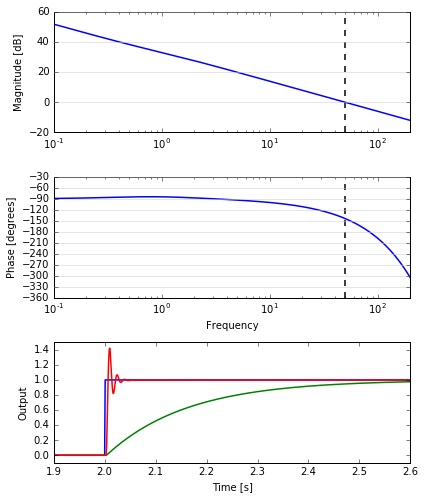

In [10]:
interact(pid_interact, delay=3, Ki=(0,10, 0.1), Kp=(1, 100, 1), Kd=(0, 0.01, 1e-3));

- The top two subplots show the Bode plot for the open loop system ($G(s)K(s)$)
    - Black line and text shows *unity gain bandwidth* (where open loop magnitude equal to 1).
- The bottom subplot shows the system's time-domain response.
- Green line shows the system's dynamics without feedback
- When does the system become unstable?
    - <p style="color:white"> $G(s)K(s)$ = -1</p>
    - <p style="color:white"> Phase at unity gain bandwidth < 180° (greater than 180 degrees of phase shift)</p>
- Feedback benefits:
    - Integral eliminates proportional droop
    - Can alter system dynamics
- Feedback drawbacks / limitations
    - Feedback can make a stable system unstable!
    - *If the system is linear,* stability is determined solel the system's open loop transfer function.
        - Noise can impact the stability of a non-linear system


## Code to generate damping figures

 - Below is an interactive PID control. The sensor response is a low-pass filter at 1 Hz with an adjustable delay (in milliseconds).

Freq at gain: 50
Phase at gain: -274°


(<matplotlib.figure.Figure at 0x11bb87c90>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11b1374d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11c2c1910>))

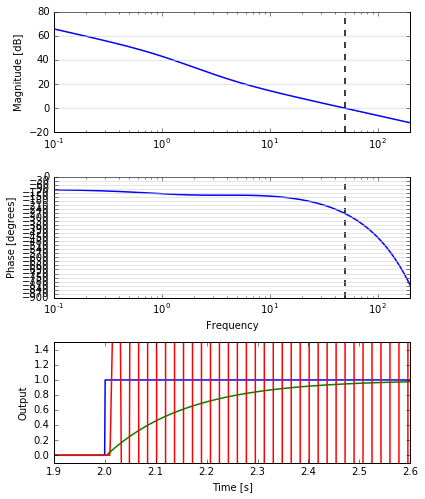

In [11]:
interact(pid_interact, delay=(0,20,1), Ki=(0,50, 0.1), Kp=(0.1, 100, 0.1), Kd=(0, 0.01, 1e-4));

Freq at gain: 10
Phase at gain: -72°


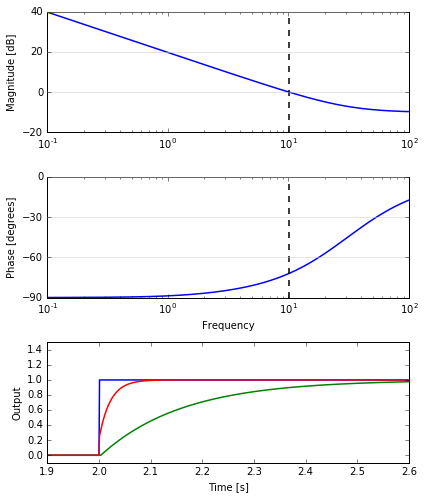

In [12]:
# Overdamped figure
fig, (ax1, ax2, ax3) = pid_interact(0, 6.2, 10, 0.005)
ax1.set_xlim(1e-1, 1e2)
ax2.set_xlim(1e-1, 1e2)
fig.tight_layout()
# fig.savefig('overdamped.png')

Freq at gain: 10
Phase at gain: -90°


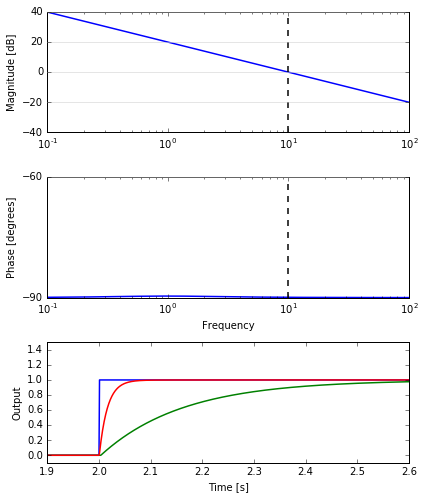

In [13]:
# Very underdamped figure
fig, (ax1, ax2, ax3) = pid_interact(0, 6.2, 10, 0)
ax1.set_xlim(1e-1, 1e2)
ax2.set_xlim(1e-1, 1e2)
fig.tight_layout()
# fig.savefig('critically-damped.png')

Freq at gain: 50
Phase at gain: -162°


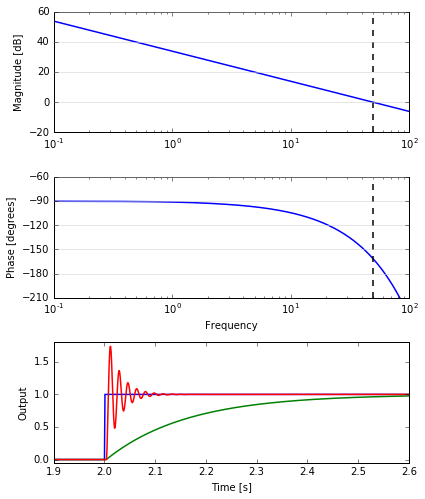

In [14]:

fig, (ax1, ax2, ax3) = pid_interact(4, 6.2, 50, 0)
ax1.set_xlim(1e-1, 1e2)
ax2.set_xlim(1e-1, 1e2)
ax2.set_ylim(-210, -60)
ax3.set_ylim(-0.05, 1.8)
fig.tight_layout()
# fig.savefig('very-underdamped.png')

Freq at gain: 29
Phase at gain: -121°


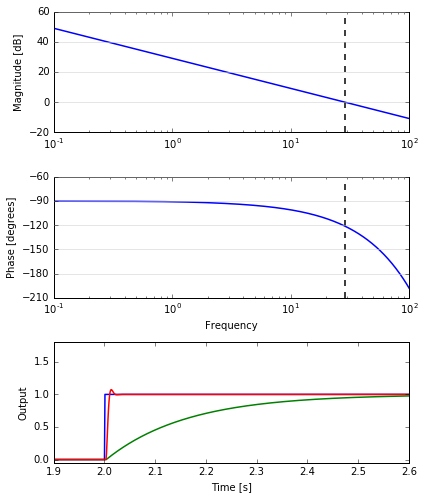

In [15]:
fig, (ax1, ax2, ax3) = pid_interact(3, 6.2, 29, 0)
ax1.set_xlim(1e-1, 1e2)
ax2.set_xlim(1e-1, 1e2)
ax2.set_ylim(-210, -60)
ax3.set_ylim(-0.05, 1.8)
fig.tight_layout()
# fig.savefig('underdamped.png')

# Stability

$$T(s) = \frac{G(s)K(s)}{1+G(s)K(s)}$$

$$L(s) = G(s)K(s)$$

- To be stable, cannot have denominator equal to -1.
- Unity-gain bandwidth $ f \; \text{where} \; |L(2 \pi i f)| = 1 $
- Stability criteria expressed in terms of the phase lag $\theta$ at $f_\text{unity gain}$
- $\; \: -90° < \theta(f_\text{unity gain}) \quad \quad \quad \;$ underdamped
- $-180° < \theta(f_\text{unity gain}) < -90° \: \: $ overdamped
- $ \; \: \quad \quad \quad   \theta(f_\text{unity gain}) < -180°$ **unstable**

## Terminology

**Phase margin:** Distance in phase from instability $\left (\theta(f_\text{unity gain}) + 180° \right )$.

**Gain margin:** Distance in magnitude from instability. For example, if the magnitude is -6 dB where the phase shift is -180°, the gain margin is 6 dB = 2.


# Overdamped

- $\theta(f_\text{unity gain}) < -90°$ overdamped

![overdamped](overdamped.png)

# Critically Damped

- $\theta(f_\text{unity gain}) = -90°$

![critically damped](critically-damped.png)

- $-90°$ for critical damping based on an approximation—in practice there's not much point in aiming for precisely critical damping.

# Underdamped

- $\theta(f_\text{unity gain}) < -90°$

The plot below has $\theta(f_\text{unity gain}) = -162°$ (18° phase margin).

![very underdamped](very-underdamped.png)

- Lots of oscillations / overshoot (high $Q$)
- System very close to instability (gain margin is 1.2)
- Minor changes to the system response could cause instability
- Time domain response is degraded severely
- Noise near $f_\text{unity gain}$ amplified by $Q$ in response


The plot below has $\theta(f_\text{unity gain}) = -120°$ (60° phase margin).

![marginally underdamped](underdamped.png)

- Fast time response / small overshoot (low $Q$)
    - need to overdamp if *any* overshoot is a problem
- System has a *gain margin* of 2.8—fairly immune to changes in the system response
- In most cases, this is roughly what you want
    - Phase margin > 45°
    - Gain margin > 2
    - High gain at DC, gain drops smoothly near the unity-gain point.
    - In a simple case, you want maximum $f_\text{unity gain}$, while still having 45–60° of phase margin. You face trade offs between bandwidth and phase margin.


# Open-loop transfer function

Because you can see both the system's frequency response, and, by looking at the unity-gain bandwidth / phase margin, the time-domain response, it is useful to look at the open-loop transfer function. It makes it easier to see / reason about both the frequency and time domains at once.

We can easily measure the open-loop transfer function in most cases—just disconnect the feedback, and measure input / output directly.

![open loop transfer function](feedback-loop-open.png)

# Laplace transform building blocks

- Here are building blocks for constructing / approximating control transfer functions. We'll pay particular attention to how the elements can affect stability.

## Low pass filter

$$G(s) = \frac{1}{1+s/\omega_0}$$

$$G(s) = \frac{1}{1+s \tau}$$

- Important for feedback, because almost every sensor looks like a low-pass filter at some frequency.
- Higher order filters correspond to high order polynomials in the denominator

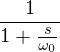

In [16]:
low_pass = 1/(1+s/omega_0)
low_pass

Freq at gain: 1
Phase at gain: -45°


(<matplotlib.figure.Figure at 0x11e3f86d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11e06f790>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11cd7fed0>))

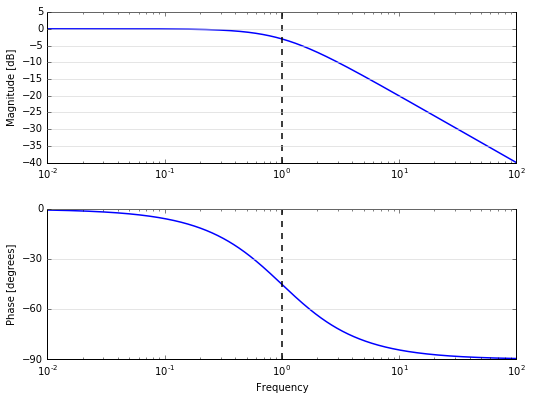

In [17]:
bode_plot_s(low_pass.subs(omega_0, 2*np.pi), s, xlim=(0.01, 100), gain_point=-3, mag_lim=(-40, 5, 5))

- 45° of phase shift at -3 dB point
- Magnitude drops at 20 dB/decade = 6dB/octave for 1st order, 40 dB/decade = 12 dB/octave for 2nd order, etc.
- There will typically be multiple low-pass filters in any feedback system (sensors, op-amps, data converters (ADC/DAC) all have finite bandwidths).

{'gain_point': -10.0, 'f_0': 5.0}
Freq at gain: 15
Phase at gain: -72°


(<matplotlib.figure.Figure at 0x11c67f7d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11f4ac910>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11ca4f790>))

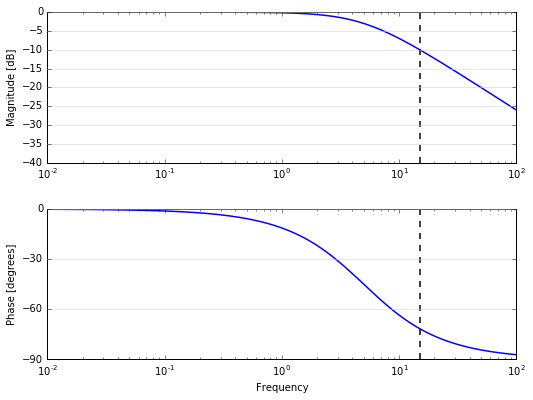

In [18]:
f_0 = sm.Symbol('f_0')
f_dB = sm.Symbol('f_dB')
bode_plot_interact(low_pass.subs(omega_0, 2*sm.pi*f_0), s, (0.01, 100), N=1000,
                   mag_lim=(-40, 0, 5), subs={f_0: (0.1, 10, 0.1)}, plot_kwargs={'gain_point': (-20,0, 0.5)})

## Delay

$$G(s) = e^{-s\tau_d}$$

In [19]:
delay = sm.exp(-s*tau_d)
delay

Freq at gain: 0.1
Phase at gain: -0°


(<matplotlib.figure.Figure at 0x11cdbd190>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x118a83c90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11e7cc710>))

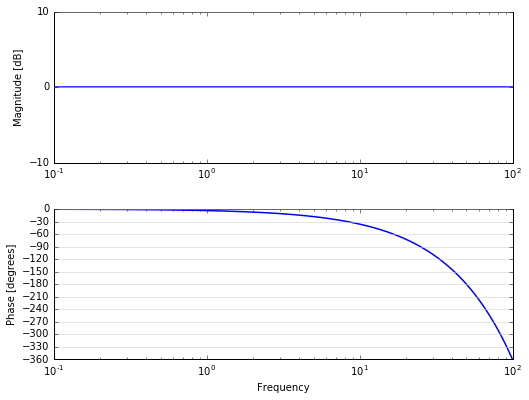

In [20]:
bode_plot_s(delay.subs(tau_d, 0.01),s ,(0.1, 100), mag_lim=(-10, 10, 10), phase_lim=(-360, 0, 30))

- A delay of $\tau_d$ seconds adds 360 degrees phase shift per $1/\tau_d$ hertz.
- In this example, a 10 ms delay adds 3.6 degrees of phase shift per Hz.
- **Delays put intrinsic limits on feedback bandwidth. Cannot "cancel" a delay with feedback (unlike low-pass filters).**

## Integral

$$G(s) = \frac{K_i}{s}$$

In [21]:
integral = K_i/s
integral

Freq at gain: 1
Phase at gain: -90°


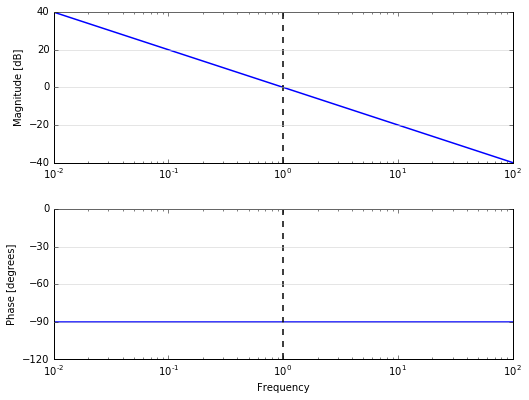

In [22]:
fig_int, (ax1_int, ax2_int) = bode_plot_s(integral.subs(K_i, 2*sm.pi), s, (0.01, 100), phase_lim=(-120, 0, 30))

- Gain goes to infinity at $f = 0$, which eliminates steady-state errors.
- Adds 90 degrees of phase shift at all frequencies (destabilizing—if you want a 45° phase margin, you can only afford 45° of phase shift from other parts of the system).
- Note: Any other transfer function with the same slope in magnitude will have the same 90 degree phase shift. For example,

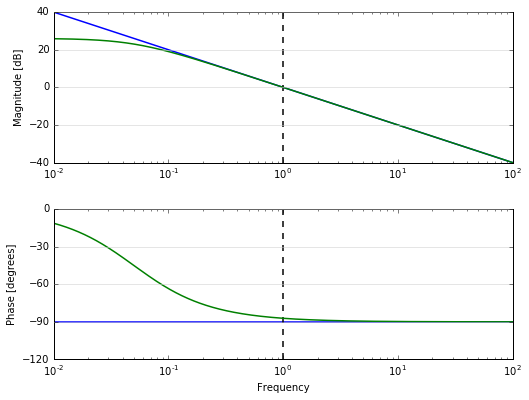

In [23]:
lp_f, lp_mag, lp_phase = get_bode_s(1/(0.05)*low_pass.subs(omega_0, 2*np.pi*0.05), s, (0.01, 100), 1000)
ax1_int.semilogx(lp_f, lp_mag, linewidth=1.5)
ax2_int.semilogx(lp_f, lp_phase, linewidth=1.5)
fig_int.gca()
fig_int

Note that far from the low pass filter cutoff, the integral control and first order low pass look the same.

You can also use PI control ($ K(s) = K_p(K_i/s + 1)$) to "cancel" a low-pass filter at $\omega_0$, by setting $K_i = \omega_0$.

Freq at gain: 0.01
Phase at gain: -1°
Freq at gain: 1
Phase at gain: -90°


(<matplotlib.figure.Figure at 0x11f322290>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11f630a50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x120e7c3d0>))

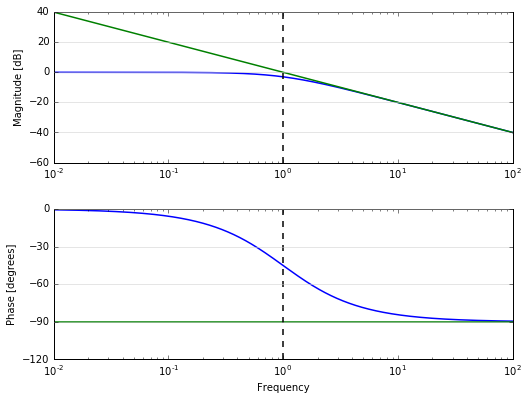

In [24]:
figax_cancel = bode_plot_s(low_pass.subs(omega_0, 2*sm.pi), s, (0.01, 100));
bode_plot_s(low_pass.subs(omega_0, 2*sm.pi)*(2*sm.pi/s + 1), s, (0.01, 100), phase_lim=(-120, 0, 30), figax=figax_cancel)

- Green curve cancels low-pass filter
- We could increase the bandwidth of the response by increasing $K_p$.

# Derivative control

$$G(s) = K_d s$$

Here is a PD controller below.

Freq at gain: 1e+05
Phase at gain: 90°


(<matplotlib.figure.Figure at 0x120eaad50>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11f46c290>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1213dc150>))

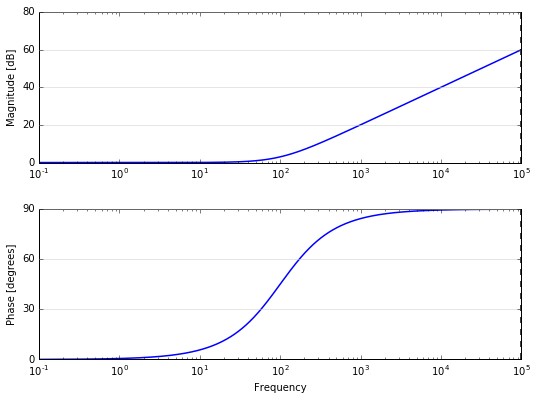

In [25]:
bode_plot_s((1 + K_d*s).subs(K_d, 1/(2*sm.pi*100)), s, (0.1, 100000))

- Derivative looks problematic on its own (amplifies high-frequencies by an infinite amount!)
- But note that it provides a *positive* phase shift, which in a feedback loop will *improve* stability.
- In the example below, band-limited derivative control helps increase phase margin of the system.

Freq at gain: 1.3e+02
Phase at gain: -120°


(<matplotlib.figure.Figure at 0x121645890>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11c391c50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x12186b6d0>))

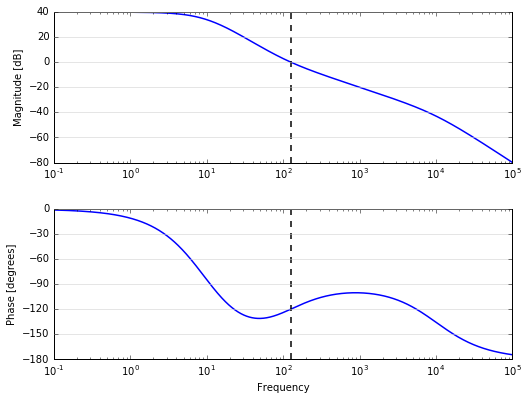

In [26]:
bode_plot_s(100*(low_pass**2*(1 + K_d*s/(1+K_d*s/100))).subs(K_d, 1/(2*sm.pi*100)).subs(omega_0, 2*sm.pi*10), s, (0.1, 100000))

Note: In this example, the band-limited PD controller is actually acting as a lead compensator.

# Other control elements

- Lead/lag compensators are "rolled off" versions of derivative and integral control; they can be used to better shape the system response function without affecting the magnitude response as dramatically.


## PID control of a low-pass filter sensor with delay, revisited

Here is the toy example to play with again.


Freq at gain: 0.1
Phase at gain: -6°


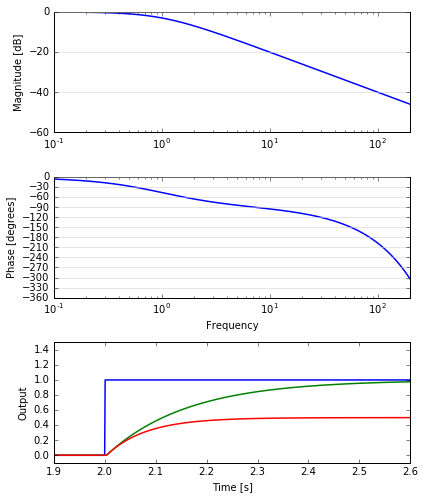

In [27]:
out = interact(pid_interact_, 
               delay=IntSlider(value=3, min=0, max=6, continuous_update=False),
               Ki=FloatSlider(value=0, min=0, max=100, step=0.1, continuous_update=False, description=r'$K_\text{i}$'),
               Kp=FloatSlider(value=1, min=0, max=500, step=1, continuous_update=False, description=r'$K_\text{p}$'),
               Kd=FloatSlider(value=0, min=0, max=0.005, step=1e-4, continuous_update=False, description=r'$K_\text{d}$'));

- PID loops are often tuned by looking at the time-domain response to a step input as shown in the lowest graph. You should be able to see how changing the delay and gains affects the overall stability.
- Try to tune the PID loop to a fast response (red line) with minimal overshoot and good stability. Check stability by trying the following:
    - Is the loop still stable if the delay is increased by 1 ms?
    - Is the loop still stable if the gain ($K_\text{p}$) is increased by a factor of 2?
- You could also try the following PID tuning [algorithm](http://machinedesign.com/mechanical-drives/twenty-minute-tune):
    - Raise $K_\text{p}$ until the system begins to overshoot.
    - Raise $K_\text{i}$ until overshoot is approximately 15%.
    - Raise $K_\text{d}$ to remove some of the overshoot.

# Non-inverting op amp

Feedback is also helpful for understanding op amp circuits.

![Non-inverting amplifier](noninverting-amplifier.png)

Assume the op-amp has a response $A(s)$. We use the voltage divider rule to express $V_\text{in}$ in terms of $V_\text{out}$.

$$
\begin{align}
V_\text{out}& = A(s)(V_+ - V_-)& \\
V_+& = V_\text{in}& \\
V_-& = \frac{R_\text{g}}{R_\text{g}+R_\text{f}} V_\text{out} = B(s) V_\text{out}& \\
\\
V_\text{out}& = A(s)(V_\text{in} - B(s)V_\text{out})& \\
V_\text{out} + A(s)B(s)V_\text{out} &= A(s)V_\text{in}& \\
\\
\frac{V_\text{out}}{V_\text{in}} = T(s)& = \frac{A(s)}{1+A(s)B(s)}& \\
B(s)& = \frac{1}{1+R_\text{f}/R_\text{g}}& \\
\end{align}
$$

Here is an appoximate model for a typical op-amp such as an AD711.

Freq at gain: 4.7e+06
Phase at gain: -118°


(<matplotlib.figure.Figure at 0x122fee850>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11f12f210>,
  <matplotlib.axes._subplots.AxesSubplot at 0x121da7f10>))

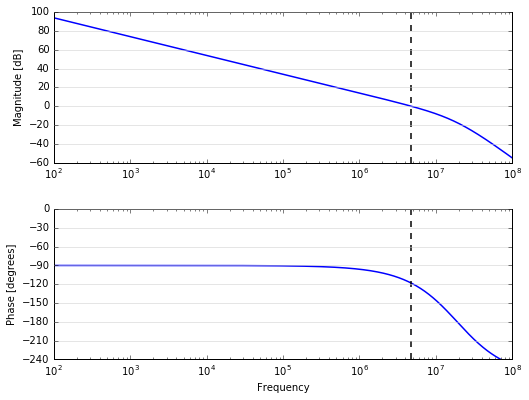

In [28]:
A = sm.symbols('A', real=True)
op_amp = 2*sm.pi*A/(s)/(1+s/(2*sm.pi*A*3.8))**2
bode_plot_s(op_amp.subs(A, 5e6), s, (100, 100e6), phase_lim=(-240, 0, 30))

This model only tries to reproduce the op-amp's unity gain bandwidth and phase margin. To account for other effects, it would be important to take into account the op-amp's output impedance, among other factors.

In [29]:
beta = 1/(1+alpha)
noninverting_ol = beta*op_amp
noninverting_cl = op_amp/(1+noninverting_ol)

In [30]:
def op_amp_response(RfRg):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
    fig.set_figwidth(6)
    fig.set_figheight(7)
    gain = RfRg + 1
    print("Gain: {:.0f}".format(gain))
    
    subs = {A:5, alpha: RfRg}
    bode_plot_s(noninverting_ol.subs(subs), s, (0.001, 10), phase_lim=(-180, -60, 30), figax=(fig, (ax1, ax2)))
    
    # Times in µs
    dt_oa = 1e-1
    t_oa = np.arange(-100, 500, dt_oa)
    x_oa = np.where(t_oa > 0, 1, 0)
    b_oa, a_oa, _ = discrete(noninverting_cl.subs(subs), s, z_i, dt_oa)

    y_oa = signal.lfilter(b_oa, a_oa, x_oa)

    plt.plot(t_oa, x_oa, t_oa, y_oa/(RfRg+1), linewidth=1.5)
    plt.ylim(-0.05, 1.2)
    plt.xlim(-1, 15)
    ax2.set_xlabel(u'Frequency [MHz]')
    ax3.set_ylabel('Normalized Output')
    ax3.set_xlabel(u'Time [µs]')
    fig.tight_layout()

Gain: 51
Freq at gain: 0.098
Phase at gain: -91°


<function __main__.op_amp_response>

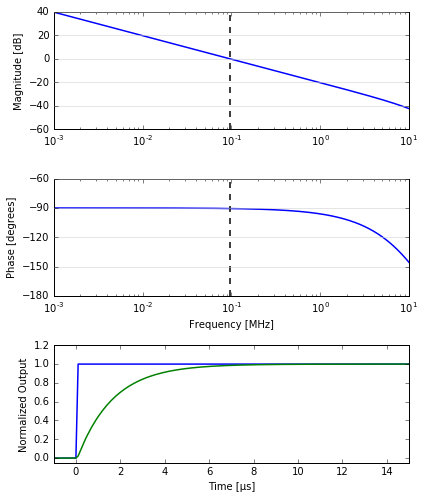

In [31]:
interact(op_amp_response, RfRg=FloatSlider(value=50, min=0, max=100, step=1, description=r"$R_\text{f}/R_\text{g}$"))

An op-amp operated at high-gain has reduced bandwidth (but also increased stability!).

# PID Loop Details

In a textbook, the PID transfer function is written as,

$$G(s) = \frac{K_i}{s} + K_p + K_d s$$

# Experimental PID Loop

PID controllers, however, often use the form,

$$G(s) = K_p \left [ \frac{K_i}{s} + 1 + K_d s \right ]$$

## Band-limited derivative

Typically, the derivative is also band-limited (the low pass filter $B(s)$ below), because the controller cannot provide, and the experimentalist would not want, arbitrarily high gains at high frequencies.

$$G(s) = K_p \left [ \frac{K_i}{s} + 1 + K_d s B(s) \right ]$$

## SRS 960

In the case of the SRS (Stanford Research Systems) 960, the controller states that the derivative term is limited to 40 dB of gain. This corresponds to a transfer function,

$$G(s) = K_p \left [ \frac{K_i}{s} + 1 + \frac{K_d s}{1 + K_d s/100} \right ]$$

In practice, this is only a factor if very high derivative gain are used.

# References

[Feedback for Physicists: A tutorial essay on control.](http://dx.doi.org/http://dx.doi.org/10.1103/RevModPhys.77.783) John Bechoefer.

- Particularly useful sections:
    - III. Feedback: An Elementary Introduction (788–794)
    - IV A-C. Feedback and Stability (795-797)
    - V A-C. Implementation (801-813)

<a href="http://dx.doi.org/10.1016/0011-2275(74)90190-8">On the use of temperature controllers in cryogenics.</a> E.M. Forgan.

In [32]:
def butter_poly(n, s):
    """Butterworth polynomials."""
    k = sm.symbols('k', integer=True)
    if n == 1:
        return s + 1
    elif n % 2 == 0:
        return sm.product(s**2 - 2*s*sm.cos((2*k+n-1)/(2*n) *sm.pi) + 1,
                          (k, 1, int(n/2)))
    else:
        return (s+1)* sm.product(s**2 - 2*s*sm.cos((2*k+n-1)/(2*n) *sm.pi) + 1,
                                 (k, 1, int((n-1)//2)))


def butter(n, s):
    """Analog low pass butterworth filter of order n."""
    return 1/butter_poly(n, s)

Freq at gain: 5.1
Phase at gain: -178°


(<matplotlib.figure.Figure at 0x1246c1850>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1246f4490>,
  <matplotlib.axes._subplots.AxesSubplot at 0x12343f750>))

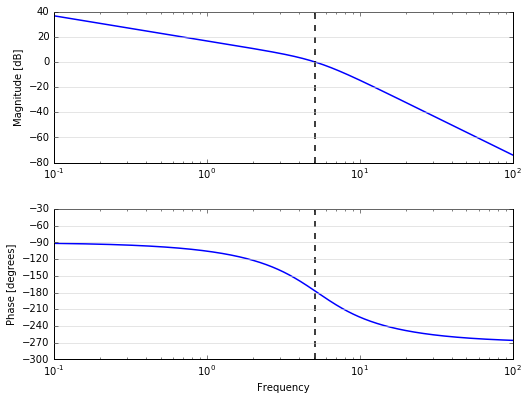

In [33]:
oloop = 45/s*butter(2, s*30e-3)
bode_plot_s(oloop, s, (0.1, 100), gain_point=0)

Freq at gain: 6.9
Phase at gain: -221°


(<matplotlib.figure.Figure at 0x122f3dcd0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11e0c3190>,
  <matplotlib.axes._subplots.AxesSubplot at 0x122ef6290>))

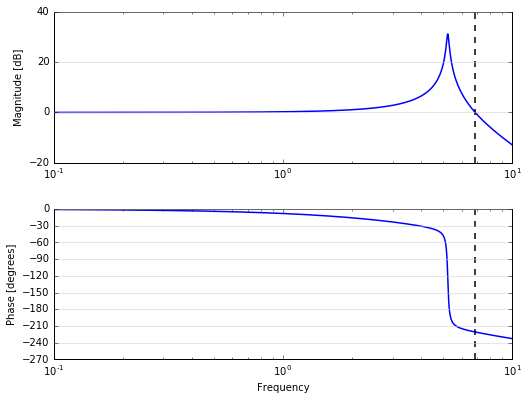

In [34]:
bode_plot_s(oloop/(1+oloop), s, (0.1, 10))